In [1]:
from astropy.io import fits
import h5py
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
DTYPE = np.float64
NSIDE = 32

In [3]:
phi = np.linspace(0, 2*np.pi, 360, endpoint=False)
theta = np.linspace(0, np.pi, 181)
P, T = np.meshgrid(phi, theta)

In [4]:
# utils for healpix (taken from the croissant package)

from scipy.interpolate import RectSphereBivariateSpline

def grid_interp(data, theta, phi, to_theta, to_phi):
    """
    Interpolate on a sphere from specfied theta and phi. The data must be
    on a rectangular grid.

    Parameters
    ----------
    data : array-like
        The data to interpolate. The last two dimensions must be (theta, phi).
        Can optionally have a 0th dimmension (e.g. a frequency dimension).
    theta : 1d-array
        The polar angles (colatitudes) in radians. Must be regularly sampled
        and strictly increasing.
    phi : 1d-array
        The azimuthal angles in radians. Must be regularly sampled and strictly
        increasing. Must be in the interval [0, 2*pi).
    to_theta : array-like
        The polar angles to interpolate to in radians.
    to_phi : array-like
        The azimuthal angles to interpolate to in radians.

    Returns
    -------
    interp_data : np.ndarray
        The interpolated data.

    """
    theta = np.ravel(theta).copy()
    phi = np.ravel(phi).copy()
    data = np.array(data, copy=True).reshape(-1, theta.size, phi.size)

    # remove poles before interpolating
    pole_values = np.full((len(data), 2), None)
    northpole = theta[0] == 0
    southpole = theta[-1] == np.pi
    if northpole:
        theta = theta[1:]
        pole_values[:, 0] = data[:, 0, 0]
        data = data[:, 1:]
    if southpole:
        theta = theta[:-1]
        pole_values[:, 1] = data[:, -1, 0]
        data = data[:, :-1]

    interp_data = np.empty((len(data), to_theta.size))
    for i in range(len(data)):
        interp = RectSphereBivariateSpline(
            theta, phi, data[i], pole_values=pole_values[i]
        )
        interp_data[i] = interp(to_theta, to_phi, grid=False)
    return interp_data

def healpix2lonlat(nside, pix=None):
    """
    Compute the longtitudes and latitudes of the pixel centers of a healpix
    map.

    Parameters
    ----------
    nside : int
        The nside of the healpix map.
    pix : array-like (optional)
        Which pixels to get the longtitudes and latitudes of. Defaults to all
        pixels.

    Returns
    -------
    lon : scalar or np.ndarray
        The longtitude(s) in degrees. Range: [0, 360).
    lat : scalar or np.ndarray
        The latitude(s) in degrees. Range: [-90, 90].

    """
    if pix is None:
        pix = np.arange(hp.nside2npix(nside))
    lon, lat = hp.pix2ang(nside, pix, nest=False, lonlat=True)
    return lon, lat



def grid2healpix(data, nside, theta=None, phi=None, pixel_centers=None):
    """
    Transform data defined on a rectangular grid on a sphere to healpix map(s).
    To compute a healpix map in a different coordinate system, compute the
    pixel centers of the target coordinate system and set the keyword argument
    pixel_centers.

    Parameters
    ----------
    data : array-like
        The data to transform. The last two dimensions must be (theta, phi).
        It may have an optional 0th dimension to generate multiple maps at
        the same time.
    nside : int
        The nside of the output healpix map.
    theta : 1d-array (optional)
        The polar angles in radians. Must be in [0, pi]. Defaults to 1-degree
        sampling.
    phi : 1d-array (optional)
        The azimuthal angles in radians. Must be in [0, 2pi). Defaults to
        1-degree sampling.
    pixel_centers: 2d-array (optional)
        The centers of the pixels in radians. Must have shape (npix, 2) and be
        ordered like healpix RING pixels. The 0th column corresponds to theta
        and the 1st to phi.

    Returns
    -------
    hp_map : np.ndarray
        The healpix map(s) in RING order with shape (n_maps, n_pixels).

    """
    npix = hp.nside2npix(nside)
    if pixel_centers is not None:
        if np.shape(pixel_centers) != (npix, 2):
            raise ValueError(f"Shape must be ({npix}, 2).")
        pix_theta = pixel_centers[:, 0]
        pix_phi = pixel_centers[:, 1]
    else:
        lon, lat = healpix2lonlat(nside)
        pix_theta = np.pi / 2 - np.deg2rad(lat)
        pix_phi = np.deg2rad(lon)

    if theta is None:
        theta = np.linspace(0, np.pi, num=181)
    else:
        theta = np.array(theta, copy=True)

    if phi is None:
        phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
    else:
        phi = np.array(phi, copy=True)

    hp_map = grid_interp(data, theta, phi, pix_theta, pix_phi)
    return hp_map

In [21]:
fmin = 30e6  # start frequency
nchans = 64  # freq channels
def arange_chans(width, nchans=nchans, fmin=fmin):
    return np.arange(nchans) * width + fmin

chans = arange_chans(25e3)
zoomin = arange_chans(25e3/64)
zoomout = arange_chans(250e3)

In [49]:
with h5py.File("data/faraday2020v2.hdf5", "r") as f:
    f_depth = f["faraday_sky_mean"][:]  # faraday depth
    
with fits.open("data/wmap_band_iqumap_r9_9yr_K_v5.fits") as hdul:
    wmap = hdul["Stokes Maps"].data # mK
    I_wmap = wmap["TEMPERATURE"] / 1e3
    Q_wmap = wmap["Q_POLARISATION"] / 1e3
    U_wmap = wmap["U_POLARISATION"] / 1e3
    
# degrade maps
I_wmap = hp.ud_grade(I_wmap, NSIDE, order_in="NEST", order_out="RING")
Q_wmap = hp.ud_grade(Q_wmap, NSIDE, order_in="NEST", order_out="RING")
U_wmap = hp.ud_grade(U_wmap, NSIDE, order_in="NEST", order_out="RING")
f_depth = hp.ud_grade(f_depth, NSIDE)

# rotate maps
from croissant import rotations
from astropy.coordinates import AltAz, EarthLocation
to_frame = AltAz(location=EarthLocation(250, -30), obstime="2023-06-23T00:41")
rm = rotations.get_rot_mat("galactic", to_frame)
euler = rotations.rotmat_to_euler(rm)

rot = hp.Rotator(rot=euler, coord=None, deg=False, eulertype="ZYX")
I_wmap, Q_wmap, U_wmap = rot.rotate_map_alms([I_wmap, Q_wmap, U_wmap])

T_MAX_DEG = 90
npix_src = hp.ang2pix(NSIDE, np.rad2deg(phi), 90-T_MAX_DEG, lonlat=True).max() + 1
src_pix = np.arange(npix_src)
I_wmap = I_wmap[src_pix]
Q_wmap = Q_wmap[src_pix]
U_wmap = U_wmap[src_pix]

wmap_freq = 23e9  # Hz
I = I_wmap *  (chans.min() / wmap_freq) ** (-2.5)
Q = I_wmap *  (chans.min() / wmap_freq) ** (-2.5)
U = I_wmap *  (chans.min() / wmap_freq) ** (-2.5)

RM = f_depth[src_pix]  # XXX

In [72]:
# point source
RM = np.ones_like(src_pix)*100
tp, pp = hp.pix2ang(NSIDE, src_pix)
I = np.where(np.rad2deg(tp)<=5, 1, 0)
Q = np.where(np.rad2deg(tp)<=5, -np.cos(2*pp), 0)
U = np.where(np.rad2deg(tp)<=5, np.sin(2*pp), 0)

In [73]:
def pl_sky(I, Q, U, freqs, beta=-2.5):
    pl = np.array((freqs / freqs.min()) ** beta, dtype=DTYPE)
    sky = np.array([I, Q, U], dtype=DTYPE)
    for _ in range(pl.ndim):  # add necessary axes to sky for broadcasting
        sky = np.expand_dims(sky, axis=1)
    sky = sky * pl[None, ..., None] 
    return sky

def pol_angle(freqs, RM, ref_freq):
    c = 299792458  # m/s
    dlambda_sq = c**2 * (1/freqs**2 - 1/ref_freq**2)
    for _ in range(freqs.ndim):
        RM = np.expand_dims(RM, axis=0)
    chi = RM * dlambda_sq[..., None]
    return chi.astype(DTYPE)

def coherency(I, Q, U, faraday=False, chi=None):
    if faraday:
        P = Q + 1j * U
        P_rot = P * np.exp(2j * chi)
        Q_rot = P_rot.real
        U_rot = P_rot.imag
        T_rot = 1/2 * np.array([[I + Q_rot, U_rot], [U_rot, I - Q_rot]])
        return Q_rot.astype(DTYPE), U_rot.astype(DTYPE), T_rot.astype(DTYPE)
    else:
        T = 1/2 * np.array([[I + Q, U], [U, I - Q]])
        return T.astype(DTYPE)
    

def vis2stokes(vis_arr):
    """
    Convert simulated visibilities to Stokes parameters.
    
    Parameters
    -----------
    vis_arr: np.ndarray
        Visibilities in the order V11, V12_real, V12_imag, V22. Shape (4, nfreqs, nchans).
        
    Returns
    -------
    stokes : np.ndarray
        The Stokes parameters I, Q, and U (no V for now). 
     
    """
    V11, V12_real, V12_imag, V22 = vis_arr
    
    pI = (V11 + V22) / 2
    pQ = (V11 - V22) / 2
    pU = V12_real
    stokes = np.array([pI, pQ, pU])
    return stokes.astype(DTYPE)


def plot_vis(freqs, vis_arr, vis_arr_rot):
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
    axs[0, 0].plot(freqs, vis_arr[0], c="C0", label="V11")
    axs[0, 0].plot(freqs, vis_arr[3], c="C1", label="V22")
    axs[0, 1].plot(freqs, vis_arr_rot[0], c="C0")
    axs[0, 1].plot(freqs, vis_arr_rot[3], c="C1")
    axs[1, 0].plot(freqs, vis_arr[1], label="V12 real")
    axs[1, 0].plot(freqs, vis_arr[2], label="V12 imag")
    axs[1, 1].plot(freqs, vis_arr_rot[1])
    axs[1, 1].plot(freqs, vis_arr_rot[2])
    for ax in axs[:, 0].ravel():
        ax.legend()
    axs[0, 0].set_title("No Faraday")
    axs[0, 1].set_title("With Faraday")
    for ax in axs[1]:
        ax.set_xlabel("Frequency [MHz]")
    plt.show()

def plot_stokes(freqs, stokes_arr, stokes_arr_rot):
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey="row", constrained_layout=True)
    axs[0, 0].plot(freqs, stokes_arr[1], label="Q")
    axs[0, 1].plot(freqs, stokes_arr_rot[1], label="Q")
    axs[0, 0].plot(freqs, stokes_arr[2], label="U")
    axs[0, 1].plot(freqs, stokes_arr_rot[2], label="U")
    #axs[1, 0].plot(freqs, stokes_arr[0]**2, label="I^2")
    #axs[1, 1].plot(freqs, stokes_arr_rot[0]**2, label="I^2")
    #axs[1, 0].plot(freqs, stokes_arr[1]**2 + stokes_arr[2]**2, label="Q^2+U^2")
    #axs[1, 1].plot(freqs, stokes_arr_rot[1]**2+stokes_arr_rot[2]**2, label="Q^2+U^2")
    axs[1, 0].plot(freqs, (stokes_arr[1]**2 + stokes_arr[2]**2) / stokes_arr[0]**2, label="(Q^2+U^2)/I^2")
    axs[1, 1].plot(freqs, (stokes_arr_rot[1]**2+stokes_arr_rot[2]**2) / stokes_arr_rot[0]**2)
    axs[0, 0].legend()
    axs[1, 0].legend()
    axs[0, 0].set_title("No Faraday")
    axs[0, 1].set_title("With Faraday")
    for ax in axs[1]:
        ax.set_xlabel("Frequency [MHz]")
    plt.show()


class Simulator:
    
    def __init__(self, freqs, I, Q, U, RM, beam, beta=-2.5, spec=None, **kwargs):
        self.freqs = freqs
        self.I, self.Q, self.U = pl_sky(I, Q, U, self.freqs, beta=beta)
        self.RM = RM
        self.chi = pol_angle(self.freqs, RM, 23e9)  # 23 GHz is the WMAP frequency
        self.T = coherency(self.I, self.Q, self.U, faraday=False)
        self.Q_rot, self.U_rot, self.T_rot = coherency(self.I, self.Q, self.U, faraday=True, chi=self.chi)
        self.beam1, self.beam2 = beam
        self.spec = spec
        
        nside = kwargs["nside"]  # original nside
        pix_area = 4 * np.pi / hp.nside2npix(nside)  # pixel area
        npix = kwargs["npix"]  # actual number of pixels used (since we discarded below horizon)
        self.dOmega = np.full(npix, pix_area)  # all pixels have the same area
        
    def vis(self, faraday=True, use_spec=True):
        """
        Compute visibilities
        """
        ein = "ap, bp, ab...p, p"  # a,b : E_theta/E_phi, p : pixel axis, ... : frequency axis/axes
        norm = 2 / np.sum(np.abs(self.beam1)**2 * self.dOmega)
        #norm = 1
        if faraday:
            coherency_mat = self.T_rot
        else:
            coherency_mat = self.T
        V11 = np.einsum(ein, self.beam1, self.beam1.conj(), coherency_mat, self.dOmega)
        V22 = np.einsum(ein, self.beam2, self.beam2.conj(), coherency_mat, self.dOmega)
        V12 = np.einsum(ein, self.beam1, self.beam2.conj(), coherency_mat, self.dOmega)
        v_arr = np.real([V11, V12.real, V12.imag, V22]) * norm
        if use_spec:
            v_arr = np.sum(v_arr[:, :, None] * self.spec[None], axis=1)
        return v_arr

## Short Dipole

In [74]:
E_theta = -np.cos(T) * np.cos(P)
E_phi = np.sin(P)

short_X = np.array([E_theta, E_phi])
short_Y = np.roll(short_X, 90, axis=-1)

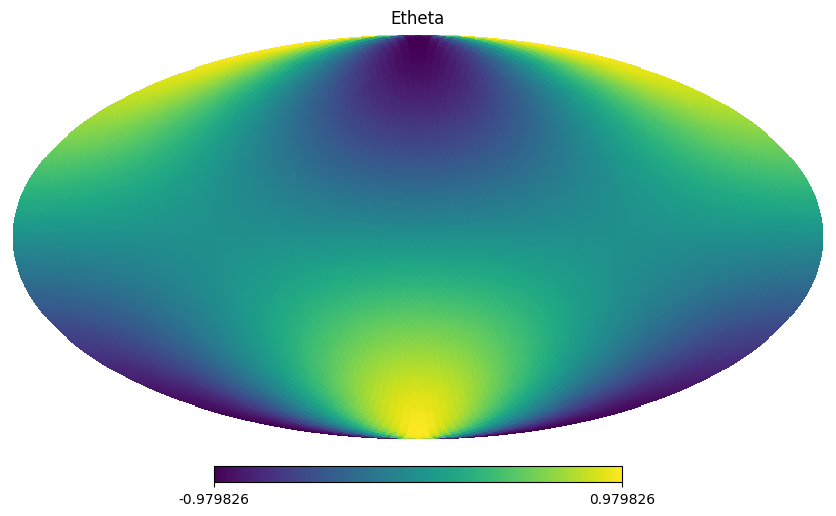

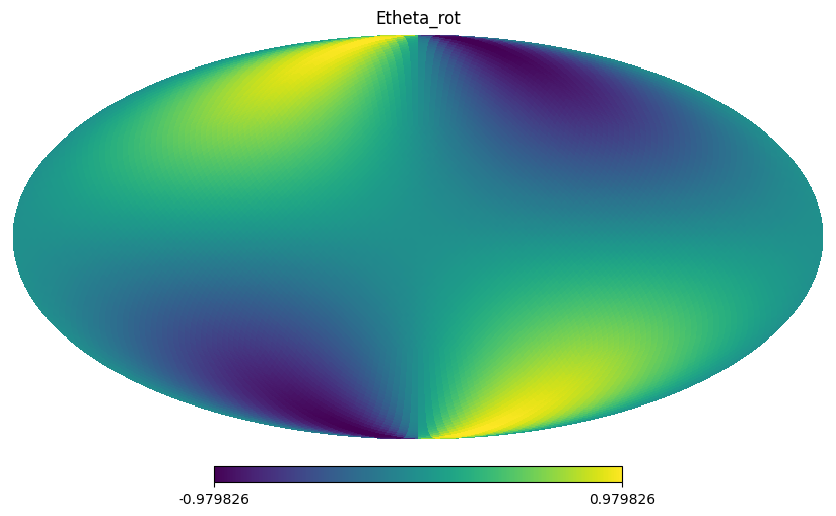

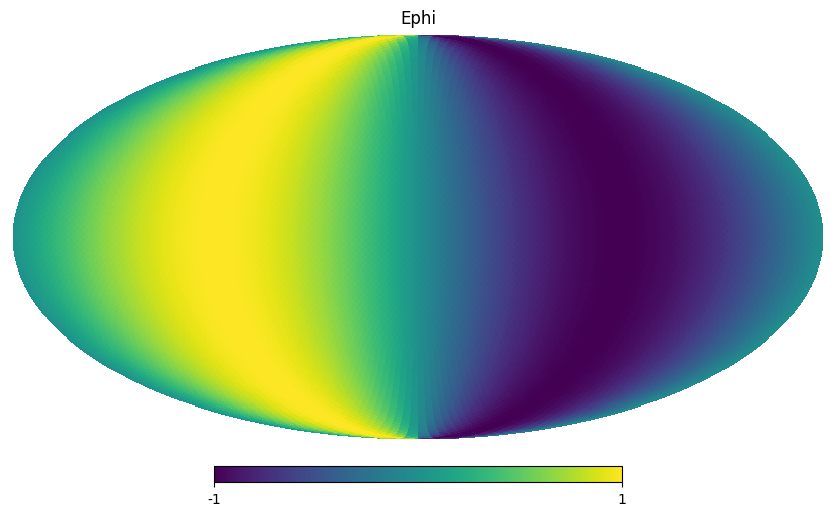

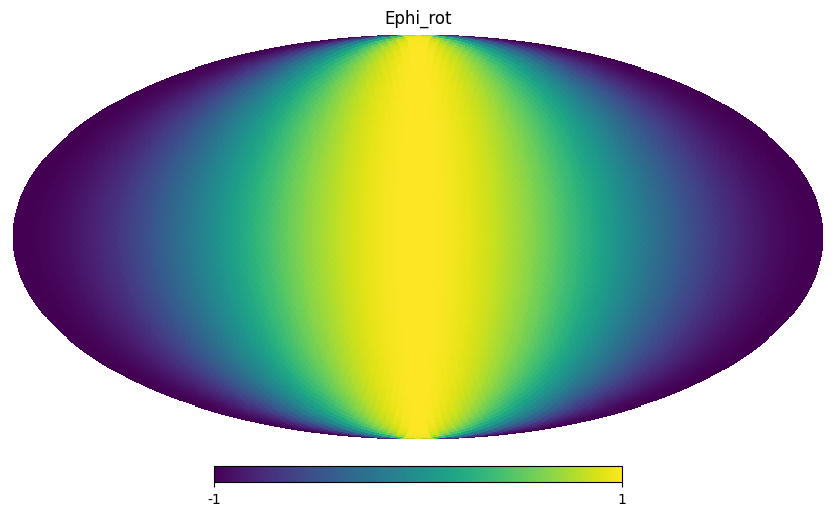

In [75]:
beam1 = grid2healpix(np.array([E_theta.real, E_theta.imag, E_phi.real, E_phi.imag]), NSIDE, theta=theta, phi=phi)
rot = hp.Rotator(rot=90, deg=True)
beam2 = np.array([rot.rotate_map_pixel(b) for b in beam1])
hp.mollview(beam1[0], title="Etheta")
hp.mollview(beam2[0], title="Etheta_rot")
hp.mollview(beam1[2], title="Ephi")
hp.mollview(beam2[2], title="Ephi_rot")

beam1 = np.array([beam1[0] + 1j* beam1[1], beam1[2] + 1j * beam1[3]])  # Etheta, Ephi
beam2 = np.array([beam2[0] + 1j* beam2[1], beam2[2] + 1j * beam2[3]])  # Etheta, Ephirot# only need beam where src is != 0

# only need beam where src is != 0
beam1 = beam1[:, :npix_src]
beam2 = beam2[:, :npix_src]
beam = np.array([beam1, beam2])

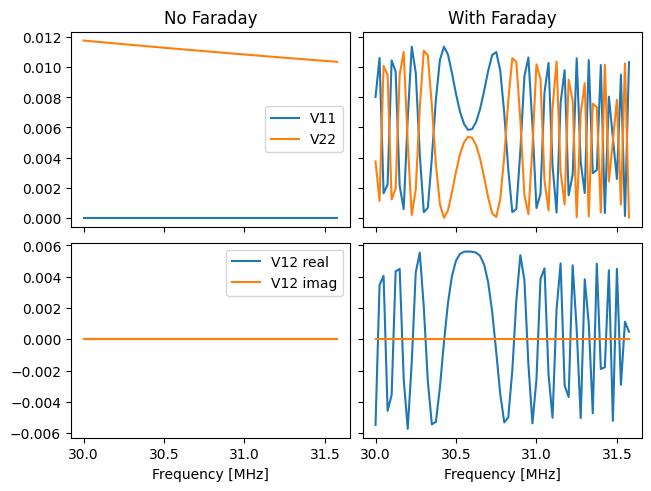

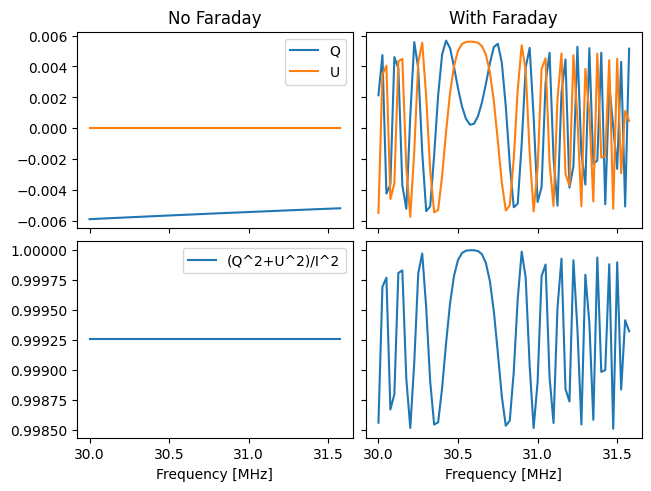

In [76]:
kwargs = {"nside": NSIDE, "npix": npix_src}
sim = Simulator(chans, I, Q, U, RM, beam, **kwargs)
vis = sim.vis(faraday=False, use_spec=False)
vis_rot = sim.vis(faraday=True, use_spec=False)
plot_vis(chans/1e6, vis, vis_rot)
plot_stokes(chans/1e6, vis2stokes(vis), vis2stokes(vis_rot))

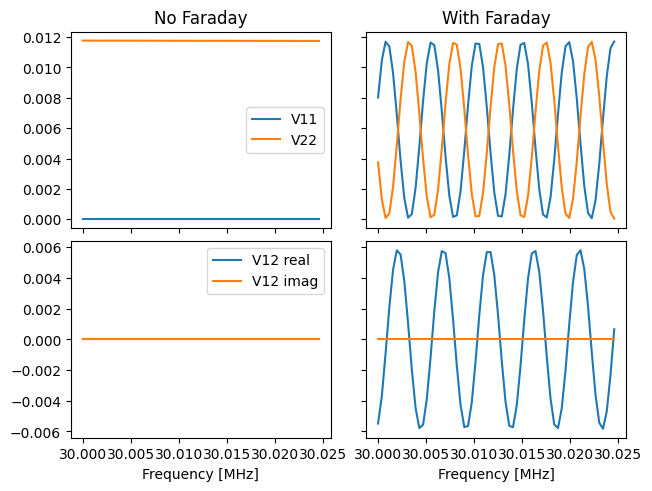

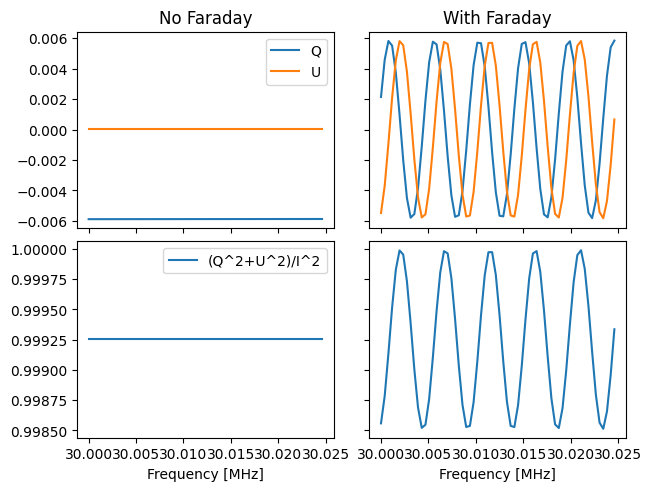

In [77]:
kwargs = {"nside": NSIDE, "npix": npix_src}
sim = Simulator(zoomin, I, Q, U, RM, beam, **kwargs)
vis = sim.vis(faraday=False, use_spec=False)
vis_rot = sim.vis(faraday=True, use_spec=False)
plot_vis(zoomin/1e6, vis, vis_rot)
plot_stokes(zoomin/1e6, vis2stokes(vis), vis2stokes(vis_rot))

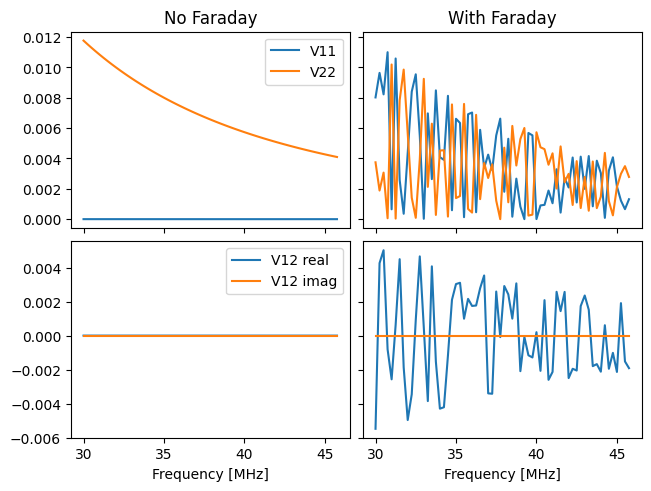

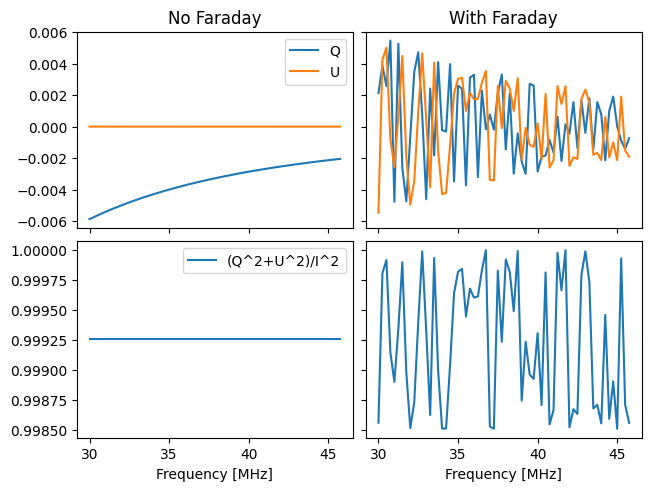

In [78]:
kwargs = {"nside": NSIDE, "npix": npix_src}
sim = Simulator(zoomout, I, Q, U, RM, beam, **kwargs)
vis = sim.vis(faraday=False, use_spec=False)
vis_rot = sim.vis(faraday=True, use_spec=False)
plot_vis(zoomout/1e6, vis, vis_rot)
plot_stokes(zoomout/1e6, vis2stokes(vis), vis2stokes(vis_rot))